# 1. Setup and Load Data
**1.1 Install Dependencies and Setup**

In [1]:
import tensorflow as tf
print(tf.__version__)


2025-08-13 10:47:17.294914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [2]:
%pip install tensorflow opencv-python matplotlib

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_x86_64.whl (56.7 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.3.1
appnope                      0.1.4
asttokens                    3.0.0
astunparse                   1.6.3
cachetools                   5.5.2
certifi                      2025.7.14
charset-normalizer           3.4.2
comm                         0.2.3
contourpy                    1.3.2
cycler                       0.12.1
debugpy                      1.8.15
decorator                    5.2.1
exceptiongroup               1.3.0
executing                    2.2.0
flatbuffers                  25.2.10
fonttools                    4.59.0
gast                         0.6.0
google-auth                  2.40.3
google-auth-oauthlib         1.2.2
google-pasta                 0.2.0
grpcio                       1.74.0
h5py                         3.14.0
idna                         3.10
ipykernel                    6.30.0
ipython                      8.37.0
jedi                         0.19.

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by limiting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices ('GPU')

[]

**1.2 Remove dodgy images**

In [7]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [8]:
data_dir = 'data'

In [13]:
import os

root_dir = 'ruta/dataset'

# Eliminar .DS_Store si existe en cualquier carpeta
for root, dirs, files in os.walk(root_dir):
    if '.DS_Store' in files:
        os.remove(os.path.join(root, '.DS_Store'))


In [14]:
os.listdir(data_dir)

['paper',
 'metal',
 'cardboard',
 'organic',
 'e-waste',
 'trash',
 'glass',
 'plastic']

In [15]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp', 'webp', 'gif']   

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [17]:
img = cv2.imread(os.path.join('data','cardboard', 'cardboard_00001.jpg'))

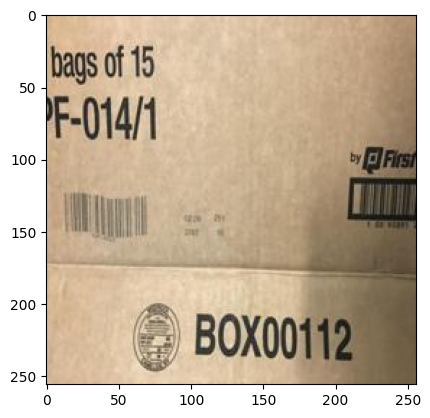

In [18]:
plt.imshow(cv2.cvtColor (img, cv2.COLOR_BGR2RGB))
plt.show()

**1.3 Load data**

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
data = tf.keras.utils.image_dataset_from_directory(
    'data',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)



Found 15861 files belonging to 8 classes.


In [21]:
data_iterator = data.as_numpy_iterator()

In [22]:
# get another batch from the iterator
batch = data_iterator.next()

In [23]:
# 0=BAUHAUS 1=BRUTALISM 2=MINIMALIST
batch[1]

array([3, 6, 2, 0, 6, 3, 0, 2, 7, 6, 5, 4, 0, 5, 4, 7, 6, 0, 5, 0, 0, 5,
       2, 2, 0, 4, 0, 4, 4, 2, 0, 7], dtype=int32)

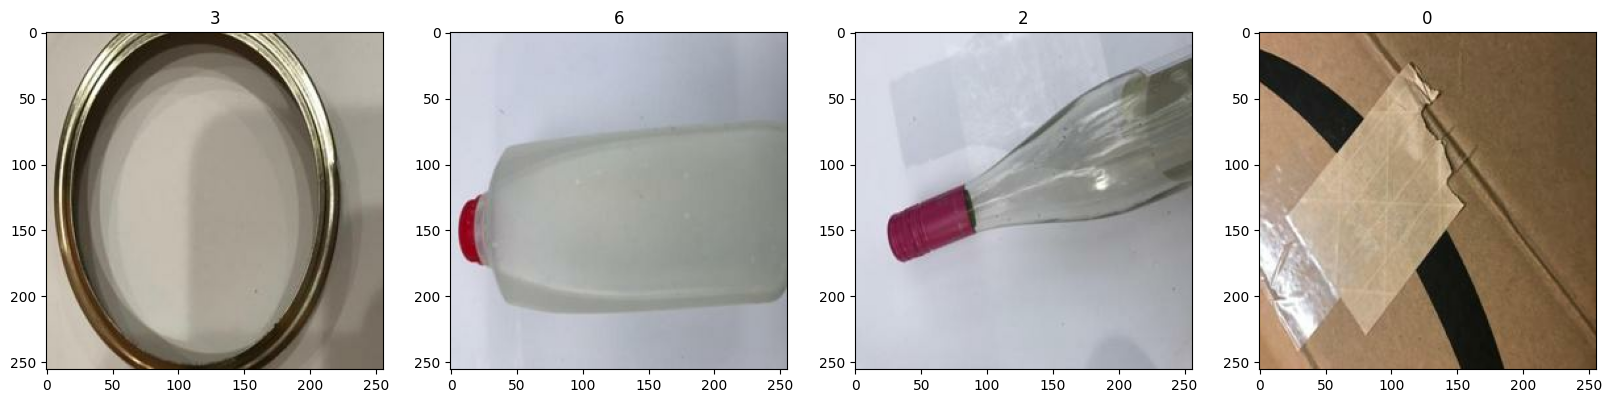

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### Images are in batch 0 and labels in batch 1

# 2. Process Data
**2.1 Scale Data**

In [25]:
data = data.map(lambda x, y: (x/255, y))

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [27]:
batch = scaled_iterator.next()

In [28]:
batch[0].max()

1.0

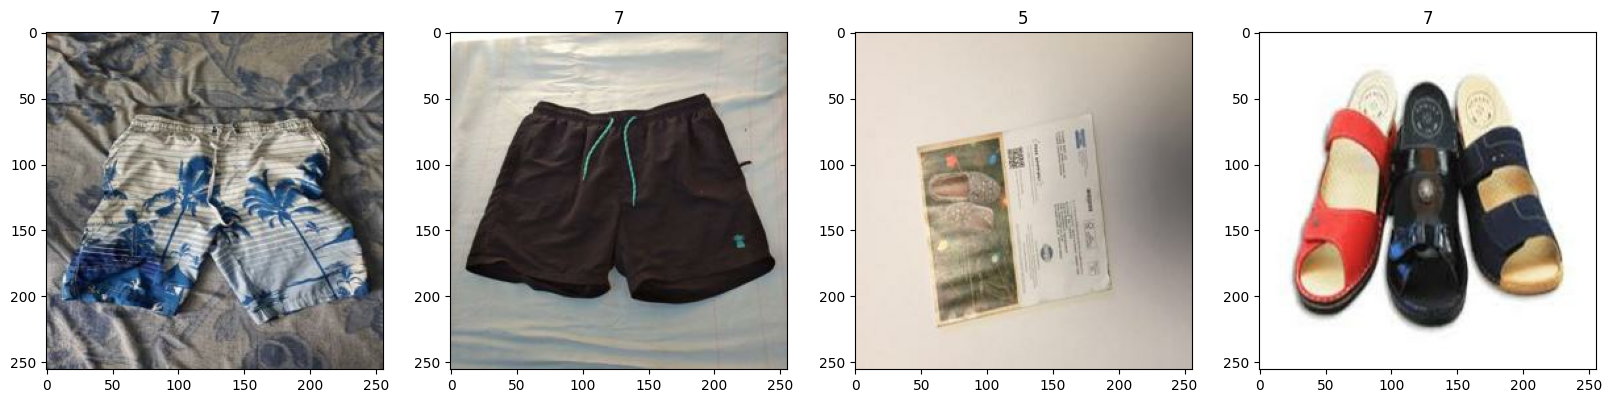

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

**2.2 Split Data into Training and Testing**

In [30]:
len(data)

496

In [33]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [34]:
train_size + val_size + test_size

496

In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Deep Model
**3.1 Build Deep Learning model**

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [37]:
model = Sequential()

In [38]:
# Bloque 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Bloque 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Bloque 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Capa densa
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Previene sobreajuste

# Salida para 8 clases
model.add(Dense(8, activation='softmax'))

In [39]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # O categorical_crossentropy según tus labels
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

**3.2 Train**

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
 80/347 [=====>........................] - ETA: 23:57 - loss: 2.0143 - accuracy: 0.2793

KeyboardInterrupt: 

**3.3 Plot Performance**

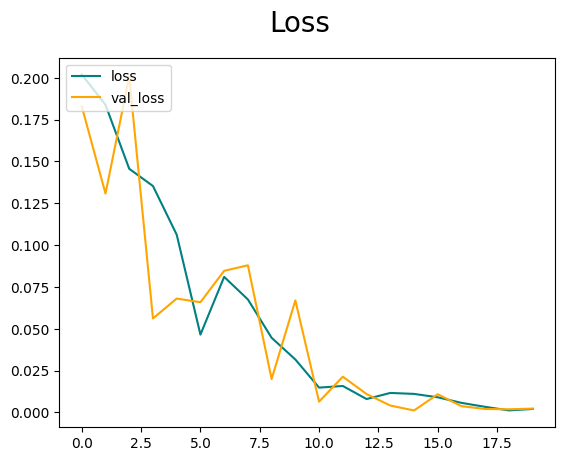

In [92]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

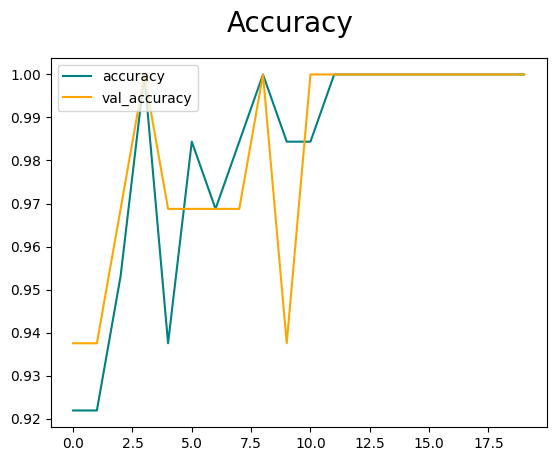

In [93]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

In [94]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [102]:
precision = Precision()
recall = Recall()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [103]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)

    # Obtener clases predichas (índice del valor más alto)
    yhat_classes = np.argmax(yhat, axis=1)

    # Actualizar métricas con clases predichas e ideales
    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)
    accuracy.update_state(y, yhat)  # SparseCategoricalAccuracy sí acepta logits softmax

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


2025-08-06 11:08:12.716232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [104]:
print(f'Precission: {precision.result().numpy()}, Recall:{recall.result().numpy()},Accuracy:{accuracy.result().numpy()}')

Precission: 1.0, Recall:1.0,Accuracy:1.0


# 5.Test

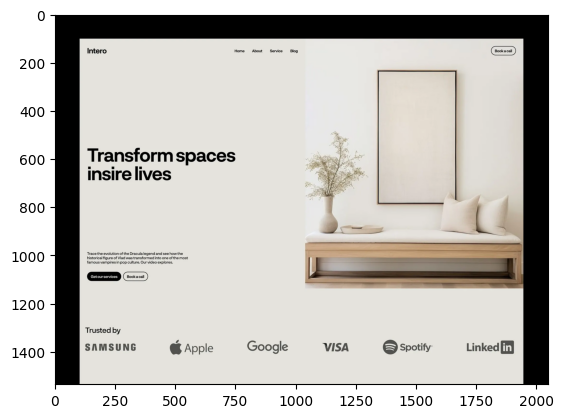

In [111]:
img = cv2.imread('MinimalTest.webp')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

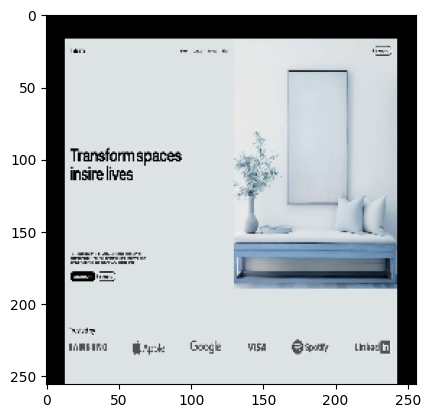

In [112]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [113]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [114]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [115]:
yhat

array([[9.9917054e-01, 7.6364947e-04, 6.5845423e-05]], dtype=float32)

In [116]:
# 0=BAUHAUS 1=BRUTALISM 2=MINIMALIST

predicted_class = np.argmax(yhat)
class_names = ['bauhaus', 'brutalism', 'minimalist']
print(f'Predicted class is {class_names[predicted_class]}')
print(f'Probabilities: {yhat[0]}')

Predicted class is bauhaus
Probabilities: [9.9917054e-01 7.6364947e-04 6.5845423e-05]
